## 1. Importing the necessary libraries

In [3]:
import json
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import en_core_web_sm
nlp = en_core_web_sm.load()
from textblob import TextBlob

# Importing libraries required for the case study and to plot charts
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px
%matplotlib inline

# Importing Regular Expressions for String manipulation
import re

# Hide warnings
import warnings
warnings.filterwarnings('ignore')



## 2. Loading the data

In [4]:

# Opening JSON file
j = open('complaints-2021-05-14_08_16.json',)

# Returns JSON object as a dictionary
data = json.load(j)

# Create a dataframe out of dictionary
df = pd.json_normalize(data)

# Inspect the dataframe to understand the given data.
df.head()


,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,...,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [5]:
# Shape of dataframe
df.shape


(78313, 22)

In [6]:
# Print the column names
df.columns

Index(['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code',
       '_source.complaint_id', '_source.issue', '_source.date_received',
       '_source.state', '_source.consumer_disputed', '_source.product',
       '_source.company_response', '_source.company', '_source.submitted_via',
       '_source.date_sent_to_company', '_source.company_public_response',
       '_source.sub_product', '_source.timely',
       '_source.complaint_what_happened', '_source.sub_issue',
       '_source.consumer_consent_provided'],
      dtype='object')

## 3. Data Preparation

In [7]:
# Assign new column names
df = df[['_source.complaint_what_happened','_source.product','_source.sub_product']]
df.head()

,_source.complaint_what_happened,_source.product,_source.sub_product
0,,Debt collection,Credit card debt
1,Good morning my name is XXXX XXXX and I apprec...,Debt collection,Credit card debt
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Credit card or prepaid card,General-purpose credit card or charge card
3,,Mortgage,Conventional home mortgage
4,,Credit card or prepaid card,General-purpose credit card or charge card


In [8]:
# Rename the column names to be more read-friendly
df = df.rename(columns={'_source.complaint_what_happened': 'complaint_text', '_source.product': 'category', '_source.sub_product': 'sub_category'})
df.head()

,complaint_text,category,sub_category
0,,Debt collection,Credit card debt
1,Good morning my name is XXXX XXXX and I apprec...,Debt collection,Credit card debt
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Credit card or prepaid card,General-purpose credit card or charge card
3,,Mortgage,Conventional home mortgage
4,,Credit card or prepaid card,General-purpose credit card or charge card


In [9]:
# Merge the category and sub-category
df['category'] = df['category'] + '+' + df['sub_category']
df = df.drop(['sub_category'], axis=1)
df.head()

,complaint_text,category
0,,Debt collection+Credit card debt
1,Good morning my name is XXXX XXXX and I apprec...,Debt collection+Credit card debt
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Credit card or prepaid card+General-purpose cr...
3,,Mortgage+Conventional home mortgage
4,,Credit card or prepaid card+General-purpose cr...


In [10]:
# Check the NaN complaints
df.complaint_text.isnull().sum()

# Check the empty string complaints
len(df[df['complaint_text']==''])

# Replace empty complaints with NaN values
df[df['complaint_text']==''] = np.nan
df.complaint_text.isnull().sum()

# Remove all rows where complaints column is NaN
df = df[~df['complaint_text'].isnull()]
df.complaint_text.isnull().sum()
df.head()

,complaint_text,category
1,Good morning my name is XXXX XXXX and I apprec...,Debt collection+Credit card debt
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Credit card or prepaid card+General-purpose cr...
10,Chase Card was reported on XX/XX/2019. However...,"Credit reporting, credit repair services, or o..."
11,"On XX/XX/2018, while trying to book a XXXX XX...","Credit reporting, credit repair services, or o..."
14,my grand son give me check for {$1600.00} i de...,Checking or savings account+Checking account


In [11]:
print(f'Shape of data frame: {df.shape}')

Shape of data frame: (21072, 2)


## 4. Text Preprocessing

In [12]:
def clean_texts(text):
    # Make the text lowercase
    text = text.lower()

    # Remove text in square brackets
    text = re.sub(r'\[.*?\]', '', text)

    # Remove punctuation
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)

    # Remove words containing numbers
    text = re.sub(r'\w*\d\w*', '', text)

    return text

# Cleaning df['complaint_what_happened']
df['complaint_text'] = df['complaint_text'].apply(lambda x: clean_texts(x))
df.head()

,complaint_text,category
1,good morning my name is xxxx xxxx and i apprec...,Debt collection+Credit card debt
2,i upgraded my xxxx xxxx card in and was told ...,Credit card or prepaid card+General-purpose cr...
10,chase card was reported on however fraudulent...,"Credit reporting, credit repair services, or o..."
11,on while trying to book a xxxx xxxx ticket ...,"Credit reporting, credit repair services, or o..."
14,my grand son give me check for i deposit it i...,Checking or savings account+Checking account


In [13]:
def lemma_texts(text):
    # Initialize empty list to store lemmas
    lemma_list = []

    # Extract lemmas of given text and add to the list
    document = nlp(text)
    for word in document:
        lemma_list.append(word.lemma_)

    # Return string converted form of the list of lemmas
    return " ".join(lemma_list)

# Add a column for lemmatized complaints to the dataframe
df["lemmatized_complaint"] = df.apply(lambda x: lemma_texts(x['complaint_text']), axis=1)
df.head()

,complaint_text,category,lemmatized_complaint
1,good morning my name is xxxx xxxx and i apprec...,Debt collection+Credit card debt,good morning my name be xxxx xxxx and I apprec...
2,i upgraded my xxxx xxxx card in and was told ...,Credit card or prepaid card+General-purpose cr...,I upgrade my xxxx xxxx card in and be tell b...
10,chase card was reported on however fraudulent...,"Credit reporting, credit repair services, or o...",chase card be report on however fraudulent a...
11,on while trying to book a xxxx xxxx ticket ...,"Credit reporting, credit repair services, or o...",on while try to book a xxxx xxxx ticket ...
14,my grand son give me check for i deposit it i...,Checking or savings account+Checking account,my grand son give I check for I deposit it i...


In [14]:
# Create a dataframe ('df_clean') that will have only the complaints and the lemmatized complaints
df_clean = df[['complaint_text', 'lemmatized_complaint']]
df_clean.head()

,complaint_text,lemmatized_complaint
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...
2,i upgraded my xxxx xxxx card in and was told ...,I upgrade my xxxx xxxx card in and be tell b...
10,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...
11,on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket ...
14,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...


In [15]:
import nltk

# Extracting singular nouns
def singular_nouns(text):
    # Creating a textblob object
    text_blob = TextBlob(text)

    # Extracting words with tag 'NN', joining them, and returning
    return ' '.join([word for (word, tag) in text_blob.tags if tag == "NN"])

# Applying the function to create a new column containing only singular nouns
df_clean["complaint_POS_removed"] = df_clean.apply(lambda x: singular_nouns(x['lemmatized_complaint']), axis=1)
df_clean.head()

,complaint_text,lemmatized_complaint,complaint_POS_removed
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank cardmember service ask ...
2,i upgraded my xxxx xxxx card in and was told ...,I upgrade my xxxx xxxx card in and be tell b...,card agent upgrade date agent information orde...
10,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...,card report application identity consent servi...
11,on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket ...,try book xxxx ticket offer ticket card informa...
14,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...,son chase account fund bank account pay money ...


## 5. Exploratory Data Analysis

In [16]:
# Length of character in 'complaint_POS_removed'
char_len = [len(x) for x in df_clean['complaint_POS_removed']]
char_len[:15]

[159, 105, 74, 414, 161, 7, 629, 585, 1186, 51, 27, 198, 122, 132, 609]

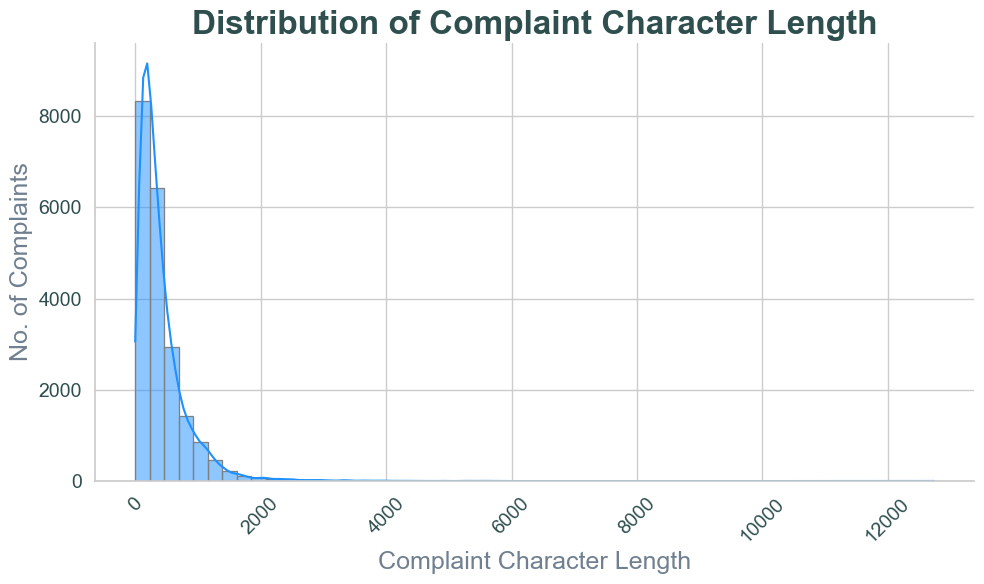

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS

# Set the style and palette for a modern, clean look
plt.figure(figsize=[10,6])
sns.set_theme(style="whitegrid", palette="muted")

# Modernize the histogram with KDE, and adjust bar and edge colors
sns.histplot(data=char_len, bins=55, kde=True, color="dodgerblue", edgecolor='gray')

# Title and Labels with refined style
plt.title('Distribution of Complaint Character Length', fontsize=24, weight='bold', color="darkslategray")  # Darker title
plt.xlabel('Complaint Character Length', fontsize=18, color='slategray')  # Darker axis label
plt.ylabel('No. of Complaints', fontsize=18, color='slategray')  # Darker axis label

# Adjusting tick size, font size, and rotating x-axis labels for readability
plt.xticks(fontsize=14, rotation=45, color='darkslategray')  # Darker x-axis ticks
plt.yticks(fontsize=14, color='darkslategray')  # Darker y-axis ticks

# Remove top and right spines for a cleaner look
sns.despine()

# Adjust the layout to make sure everything fits
plt.tight_layout()

# Display the plot
plt.show()

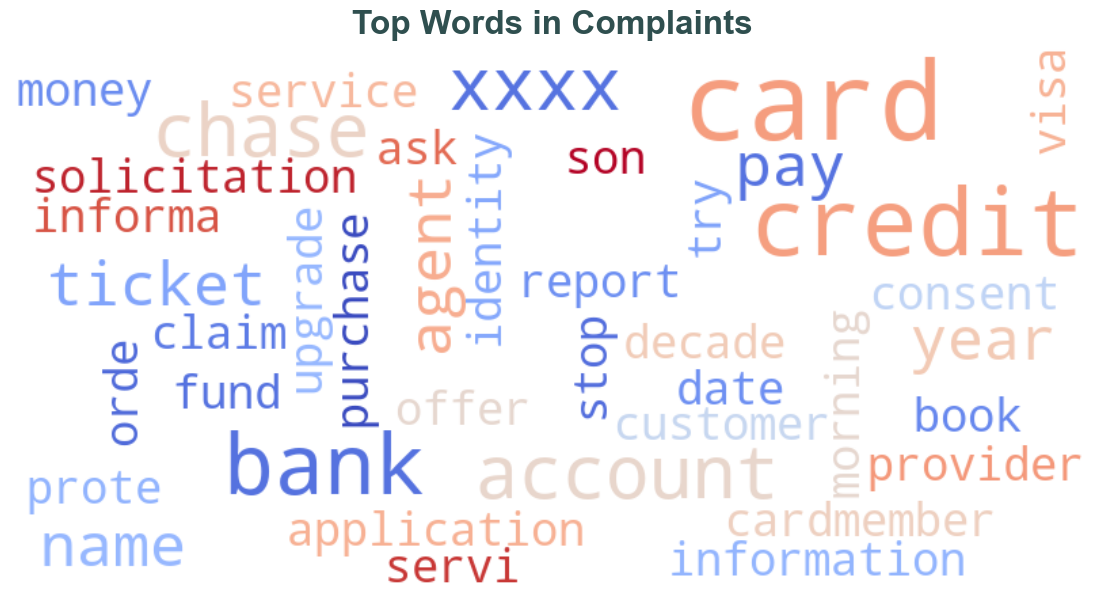

In [18]:
# Modernizing the WordCloud Visualization
stop_words = set(STOPWORDS)

# Generate word cloud with modern styling
word_cloud = WordCloud(
    background_color='white',
    stopwords=stop_words,
    max_font_size=80,
    max_words=40,
    colormap='coolwarm',  # A cooler, modern palette
    contour_width=0,
    contour_color='black',
    random_state=42,
    width=800,
    height=400,
    prefer_horizontal=0.8
).generate(str(df_clean['complaint_POS_removed']))

# Displaying the Word Cloud with a polished look
plt.figure(figsize=(14,8))
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.title('Top Words in Complaints', fontsize=24, weight='bold', color="darkslategray")
plt.show()

In [19]:
from sklearn.feature_extraction.text import CountVectorizer

def get_top_n_bigram(text, ngram=1, top=None):
    vec = CountVectorizer(ngram_range=(ngram, ngram), stop_words='english').fit(text)
    bag_of_words = vec.transform(text)

    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]

    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:top]

top_30_unigrams = get_top_n_bigram(df_clean.complaint_POS_removed, ngram=1, top=30)
top_30_bigrams = get_top_n_bigram(df_clean.complaint_POS_removed, ngram=2, top=30)
top_30_trigrams = get_top_n_bigram(df_clean.complaint_POS_removed, ngram=3, top=30)

In [20]:
# Print the top 10 unigrams
print('Top 10 unigrams:\n')
df_unigram = pd.DataFrame(top_30_unigrams, columns=['unigram', 'count'])
print(df_unigram.head(10))

Top 10 unigrams:

   unigram  count
0  account  47484
1    chase  46577
2     xxxx  36540
3   credit  34146
4     card  29278
5     bank  28402
6  payment  21167
7     time  16023
8   charge  14994
9      day  12970


In [ ]:
# Plot the top 30 unigrams using Plotly
fig_unigram = px.bar(df_unigram, 
                     x='unigram', 
                     y='count', 
                     color='count', 
                     color_continuous_scale='Blues',  # Smooth color scale for the bars
                     title="Top 30 Unigrams in Complaints",
                     labels={'unigram': 'Unigrams', 'count': 'Frequency'},
                     text='count')

# Update traces for text positioning and color
fig_unigram.update_traces(
    texttemplate='%{text}', 
    textposition='outside', 
    marker=dict(line=dict(width=1, color='DarkSlateGray')),
    cliponaxis=False  # Prevent clipping of text outside bars
)

# Make the frequency numbers and text darker and more readable
fig_unigram.update_traces(textfont=dict(color='black'))  # Make frequency numbers black for better contrast

# Update layout for better readability
fig_unigram.update_layout(
    title=dict(
        font=dict(size=24, color='darkslategray', family="Arial"),  # Darker title color
    ),
    xaxis=dict(
        title=dict(font=dict(size=16, color='darkslategray')),  # Darker axis title
        tickfont=dict(size=14, color='darkslategray'),  # Darker tick font color
        tickangle=-45,  # Angle x-axis labels for better readability
        automargin=True,  # Automatically adjust margins to fit labels
    ),
    yaxis=dict(
        title=dict(font=dict(size=16, color='darkslategray')),  # Darker y-axis title
        tickfont=dict(size=14, color='darkslategray')  # Darker y-axis ticks
    ),
    font=dict(size=14, family="Arial, sans-serif", color='darkslategray'),  # General text font styling
    paper_bgcolor='white',  # Set background to white for better contrast
    plot_bgcolor='rgba(0, 0, 0, 0)',  # Transparent background for the plot area
    showlegend=False,  # Remove legend for a cleaner look
    margin=dict(t=150, b=50, l=50, r=50),  # Increased top margin (t) to accommodate text
    height=600  # Increase plot height for more room for labels
)

# Display the figure
fig_unigram.show()


In [23]:
fig_unigram = px.bar(df_unigram, 
                     x='unigram', 
                     y='count', 
                     color='count', 
                     color_continuous_scale=[
                         (0, '#3A855D'),  # Dark green at the beginning of the gradient
                         (1, '#A0D6B4')   # Lighter green at the end of the gradient (adjust as needed)
                     ],
                     title="Top 30 Unigrams in Complaints",
                     labels={'unigram': 'Unigrams', 'count': 'Frequency'},
                     text='count')

# Update traces for text positioning and color
fig_unigram.update_traces(
    texttemplate='%{text}', 
    textposition='outside', 
    marker=dict(line=dict(width=1, color='DarkSlateGray')),
    cliponaxis=False  # Prevent clipping of text outside bars
)

# Make the frequency numbers and text darker and more readable
fig_unigram.update_traces(textfont=dict(color='black'))  # Make frequency numbers black for better contrast

# Update layout for better readability
fig_unigram.update_layout(
    title=dict(
        font=dict(size=24, color='darkslategray', family="Arial"),  # Darker title color
    ),
    xaxis=dict(
        title=dict(font=dict(size=16, color='darkslategray')),  # Darker axis title
        tickfont=dict(size=14, color='darkslategray'),  # Darker tick font color
        tickangle=-45,  # Angle x-axis labels for better readability
        automargin=True,  # Automatically adjust margins to fit labels
    ),
    yaxis=dict(
        title=dict(font=dict(size=16, color='darkslategray')),  # Darker y-axis title
        tickfont=dict(size=14, color='darkslategray')  # Darker y-axis ticks
    ),
    font=dict(size=14, family="Arial, sans-serif", color='darkslategray'),  # General text font styling
    paper_bgcolor='white',  # Set background to white for better contrast
    plot_bgcolor='rgba(0, 0, 0, 0)',  # Transparent background for the plot area
    showlegend=False,  # Remove legend for a cleaner look
    margin=dict(t=150, b=50, l=50, r=50),  # Increased top margin (t) to accommodate text
    height=600  # Increase plot height for more room for labels
)

# Display the figure
fig_unigram.show()

In [24]:
# Print the top 10 bigrams
print('Top 10 bigrams:\n')
df_bigram = pd.DataFrame(top_30_bigrams, columns=['bigram', 'count'])
print(df_bigram.head(10))

Top 10 bigrams:

             bigram  count
0       credit card  12781
1     credit report   3971
2         xxxx xxxx   3938
3  customer service   3080
4      chase credit   2962
5        chase bank   2946
6      bank account   2742
7     account chase   2575
8   account account   2403
9     chase account   2383


In [25]:
# Plot the top 30 bigrams using Plotly
fig_bigram = px.bar(df_bigram, 
                    x='bigram', 
                    y='count', 
                    color='count', 
                    color_continuous_scale='Viridis',  # Smooth color scale for the bars
                    title="Top 30 Bigrams in Complaints",
                    labels={'bigram': 'Bigrams', 'count': 'Frequency'},
                    text='count')

# Update traces for text positioning and color
fig_bigram.update_traces(
    texttemplate='%{text}', 
    textposition='outside', 
    marker=dict(line=dict(width=1, color='DarkSlateGray')),
    cliponaxis=False  # Prevent clipping of text outside bars
)

# Make the frequency numbers and text darker and more readable
fig_bigram.update_traces(textfont=dict(color='black'))  # Make frequency numbers black for better contrast

# Update layout for better readability
fig_bigram.update_layout(
    title=dict(
        font=dict(size=24, color='darkslategray', family="Arial"),  # Darker title color
    ),
    xaxis=dict(
        title=dict(font=dict(size=16, color='darkslategray')),  # Darker axis title
        tickfont=dict(size=14, color='darkslategray'),  # Darker tick font color
        tickangle=-45,  # Angle x-axis labels for better readability
        automargin=True,  # Automatically adjust margins to fit labels
    ),
    yaxis=dict(
        title=dict(font=dict(size=16, color='darkslategray')),  # Darker y-axis title
        tickfont=dict(size=14, color='darkslategray')  # Darker y-axis ticks
    ),
    font=dict(size=14, family="Arial, sans-serif", color='darkslategray'),  # General text font styling
    paper_bgcolor='white',  # Set background to white for better contrast
    plot_bgcolor='rgba(0, 0, 0, 0)',  # Transparent background for the plot area
    showlegend=False,  # Remove legend for a cleaner look
    margin=dict(t=150, b=50, l=50, r=50),  # Increased top margin (t) to accommodate text
    height=600  # Increase plot height for more room for labels
)

# Display the figure
fig_bigram.show()

In [26]:
# Print the top 10 trigrams
print('Top 10 trigrams:\n')
df_trigram = pd.DataFrame(top_30_trigrams, columns=['trigram', 'count'])
print(df_trigram.head(10))

Top 10 trigrams:

                 trigram  count
0      chase credit card   2061
1    credit card account   1023
2    credit card company    991
3      credit card chase    632
4     credit card credit    513
5  inquiry credit report    480
6     charge credit card    422
7         xxxx xxxx xxxx    409
8    account credit card    398
9       card credit card    386


In [27]:
# Plot the top 30 trigrams using Plotly
fig_trigram = px.bar(df_trigram, 
                     x='trigram', 
                     y='count', 
                     color='count', 
                     color_continuous_scale='Inferno',  # Smooth color scale for the bars
                     title="Top 30 Trigrams in Complaints",
                     labels={'trigram': 'Trigrams', 'count': 'Frequency'},
                     text='count')

# Update traces for text positioning and color
fig_trigram.update_traces(
    texttemplate='%{text}', 
    textposition='outside', 
    marker=dict(line=dict(width=1, color='DarkSlateGray')),
    cliponaxis=False  # Prevent clipping of text outside bars
)

# Make the frequency numbers and text darker and more readable
fig_trigram.update_traces(textfont=dict(color='black'))  # Make frequency numbers black for better contrast

# Update layout for better readability
fig_trigram.update_layout(
    title=dict(
        font=dict(size=24, color='darkslategray', family="Arial"),  # Darker title color
    ),
    xaxis=dict(
        title=dict(font=dict(size=16, color='darkslategray')),  # Darker axis title
        tickfont=dict(size=14, color='darkslategray'),  # Darker tick font color
        tickangle=-45,  # Angle x-axis labels for better readability
        automargin=True,  # Automatically adjust margins to fit labels
    ),
    yaxis=dict(
        title=dict(font=dict(size=16, color='darkslategray')),  # Darker y-axis title
        tickfont=dict(size=14, color='darkslategray')  # Darker y-axis ticks
    ),
    font=dict(size=14, family="Arial, sans-serif", color='darkslategray'),  # General text font styling
    paper_bgcolor='white',  # Set background to white for better contrast
    plot_bgcolor='rgba(0, 0, 0, 0)',  # Transparent background for the plot area
    showlegend=False,  # Remove legend for a cleaner look
    margin=dict(t=150, b=50, l=50, r=50),  # Increased top margin (t) to accommodate text
    height=600  # Increase plot height for more room for labels
)

# Display the figure
fig_trigram.show()

In [28]:
# Remove all masked 'xxxx' from the complaints column
df_clean['complaint_POS_removed'] = df_clean['complaint_POS_removed'].str.replace('xxxx', '', regex=False)

# Check the cleaned data
df_clean.head()


,complaint_text,lemmatized_complaint,complaint_POS_removed
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank cardmember service ask ...
2,i upgraded my xxxx xxxx card in and was told ...,I upgrade my xxxx xxxx card in and be tell b...,card agent upgrade date agent information orde...
10,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...,card report application identity consent servi...
11,on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket ...,try book ticket offer ticket card information...
14,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...,son chase account fund bank account pay money ...


## 6. Feature Extraction

In [29]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize the TfidfVectorizer
tfidf = TfidfVectorizer(min_df=2, max_df=0.95, stop_words='english')

# Create the Document Term Matrix by transforming the complaints column
dtm = tfidf.fit_transform(df_clean['complaint_POS_removed'])

# Display the document-term matrix shape
print(f"Shape of DTM: {dtm.shape}")
tfidf.get_feature_names_out()[:10]

Shape of DTM: (21072, 7260)


array(['aa', 'aarp', 'ab', 'abandon', 'abandonment', 'abatement',
       'abbreviation', 'abd', 'abide', 'ability'], dtype=object)

## 7. Topic Modelling using NMF (Non-Negative Matrix Factorization)

In [30]:
from sklearn.decomposition import NMF

# Define number of topics
num_topics = 5

# Initialize the NMF model with random_state for reproducibility
nmf_model = NMF(n_components=num_topics, random_state=40)
nmf_model.fit(dtm)

# Print the number of features (words) in the model
print(f"Number of words in TF-IDF model: {len(tfidf.get_feature_names_out())}")

Number of words in TF-IDF model: 7260


In [31]:
# Get the top 20 words from a sample topic
topic_single = nmf_model.components_[0]
top_word_index = topic_single.argsort()[-20:]

print("\nTop 20 words in a sample topic:")
for index in top_word_index:
    print(tfidf.get_feature_names_out()[index])


Top 20 words in a sample topic:
time
access
fraud
cash
customer
transfer
claim
checking
transaction
business
number
day
branch
deposit
chase
fund
money
check
bank
account


In [32]:
# Print the top 20 words for each topic
for index, topic in enumerate(nmf_model.components_):
    print(f"\nTOP 20 WORDS FOR TOPIC #{index}")
    print([tfidf.get_feature_names_out()[i] for i in topic.argsort()[-20:]])


TOP 20 WORDS FOR TOPIC #0
['time', 'access', 'fraud', 'cash', 'customer', 'transfer', 'claim', 'checking', 'transaction', 'business', 'number', 'day', 'branch', 'deposit', 'chase', 'fund', 'money', 'check', 'bank', 'account']

TOP 20 WORDS FOR TOPIC #1
['time', 'reason', 'identity', 'bureau', 'reporting', 'year', 'balance', 'letter', 'application', 'debt', 'information', 'limit', 'company', 'score', 'account', 'chase', 'inquiry', 'report', 'card', 'credit']

TOP 20 WORDS FOR TOPIC #2
['report', 'plan', 'history', 'car', 'error', 'mortgage', 'year', 'chase', 'account', 'credit', 'pay', 'date', 'auto', 'time', 'day', 'statement', 'fee', 'month', 'balance', 'payment']

TOP 20 WORDS FOR TOPIC #3
['state', 'customer', 'email', 'phone', 'day', 'company', 'refund', 'statement', 'time', 'service', 'purchase', 'claim', 'fraud', 'merchant', 'chase', 'dispute', 'transaction', 'fee', 'card', 'charge']

TOP 20 WORDS FOR TOPIC #4
['process', 'debt', 'request', 'state', 'information', 'sale', 'forec

In [33]:
# Assign each complaint the best topic
topic_result = nmf_model.transform(dtm)
df_clean['Topic'] = topic_result.argmax(axis=1)

# Print dataset shape and preview
print(f"\nDataset shape after adding Topic column: {df_clean.shape}")


Dataset shape after adding Topic column: (21072, 4)


In [34]:
df_clean.head()

,complaint_text,lemmatized_complaint,complaint_POS_removed,Topic
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank cardmember service ask ...,0
2,i upgraded my xxxx xxxx card in and was told ...,I upgrade my xxxx xxxx card in and be tell b...,card agent upgrade date agent information orde...,1
10,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...,card report application identity consent servi...,1
11,on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket ...,try book ticket offer ticket card information...,1
14,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...,son chase account fund bank account pay money ...,0


In [35]:
# Print the first 5 complaints for each topic
df_clean_5 = df_clean.groupby('Topic').head(5).sort_values('Topic')
df_clean_5.head(10)

,complaint_text,lemmatized_complaint,complaint_POS_removed,Topic
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank cardmember service ask ...,0
14,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...,son chase account fund bank account pay money ...,0
17,with out notice jp morgan chase restricted my ...,with out notice jp morgan chase restrict my ac...,jp chase account debit card tuesday thursday b...,0
24,mishandling of this account by chase auto and ...,mishandle of this account by chase auto and xxxx,mishandle account auto,0
27,i opened an account with chase bank on xxxx an...,I open an account with chase bank on xxxx and ...,account bank code bonus term everything accoun...,0
2,i upgraded my xxxx xxxx card in and was told ...,I upgrade my xxxx xxxx card in and be tell b...,card agent upgrade date agent information orde...,1
10,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...,card report application identity consent servi...,1
11,on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket ...,try book ticket offer ticket card information...,1
15,can you please remove inquiry,can you please remove inquiry,inquiry,1
23,i have a chase credit card which is incorrectl...,I have a chase credit card which be incorrectl...,chase credit card datum credit report company ...,1


## 8. Mapping Relevant Topic to Each Complaint

In [36]:
# Create a dictionary to map topic numbers to meaningful names
topic_mapping = {
    0: 'Bank Account Services',
    1: 'Credit Card or Prepaid Card',
    2: 'Others',
    3: 'Theft/Dispute Reporting',
    4: 'Mortgage/Loan'
}

# Replace topic numbers with names in the dataframe
df_clean['Topic'] = df_clean['Topic'].map(topic_mapping)

# Preview the updated dataframe
df_clean.head()

,complaint_text,lemmatized_complaint,complaint_POS_removed,Topic
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank cardmember service ask ...,Bank Account Services
2,i upgraded my xxxx xxxx card in and was told ...,I upgrade my xxxx xxxx card in and be tell b...,card agent upgrade date agent information orde...,Credit Card or Prepaid Card
10,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...,card report application identity consent servi...,Credit Card or Prepaid Card
11,on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket ...,try book ticket offer ticket card information...,Credit Card or Prepaid Card
14,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...,son chase account fund bank account pay money ...,Bank Account Services


In [37]:
import plotly.express as px

# Create an interactive count plot for complaint topics using Plotly
fig_topic = px.histogram(df_clean, 
                         x='Topic', 
                         color_discrete_sequence=['green'],  # Set bar color to Green
                         title='Distribution of Complaints Across Topics',
                         labels={'Topic': 'Complaint Topic', 'count': 'Count'},
                         text_auto=True)  # Automatically add the count text on top of the bars

# Update layout for better readability
fig_topic.update_layout(
    title=dict(
        font=dict(size=24, color='darkslategray', family="Arial"),  # Darker title color
    ),
    xaxis=dict(
        title=dict(font=dict(size=16, color='darkslategray')),  # Darker axis title
        tickfont=dict(size=14, color='darkslategray'),  # Darker tick font color
        tickangle=30,  # Angle x-axis labels for better readability
        automargin=True,  # Automatically adjust margins to fit labels
    ),
    yaxis=dict(
        title=dict(font=dict(size=16, color='darkslategray')),  # Darker y-axis title
        tickfont=dict(size=14, color='darkslategray')  # Darker y-axis ticks
    ),
    font=dict(size=14, family="Arial, sans-serif", color='darkslategray'),  # General text font styling
    paper_bgcolor='white',  # Set background to white for better contrast
    plot_bgcolor='rgba(0, 0, 0, 0)',  # Transparent background for the plot area
    showlegend=False,  # Remove legend for a cleaner look
    height=600  # Set plot height for a cleaner layout
)

# Display the figure
fig_topic.show()

In [38]:
# Keep only the relevant columns for training
training_data = df_clean[['complaint_text', 'Topic']]

# Preview the training dataset
print("Training Dataset")
training_data.head()

Training Dataset


,complaint_text,Topic
1,good morning my name is xxxx xxxx and i apprec...,Bank Account Services
2,i upgraded my xxxx xxxx card in and was told ...,Credit Card or Prepaid Card
10,chase card was reported on however fraudulent...,Credit Card or Prepaid Card
11,on while trying to book a xxxx xxxx ticket ...,Credit Card or Prepaid Card
14,my grand son give me check for i deposit it i...,Bank Account Services


In [39]:
# Remove masked text placeholders like 'xxxx'
training_data['complaint_text'] = training_data['complaint_text'].str.replace('xxxx', '', regex=True)

# Check class distribution (count of each topic)
print("\nClass distribution in training data:")
print(training_data['Topic'].value_counts())



Class distribution in training data:
Topic
Bank Account Services          5219
Credit Card or Prepaid Card    5001
Theft/Dispute Reporting        4774
Mortgage/Loan                  3820
Others                         2258
Name: count, dtype: int64


In [40]:
df_clean.head()

,complaint_text,lemmatized_complaint,complaint_POS_removed,Topic
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank cardmember service ask ...,Bank Account Services
2,i upgraded my xxxx xxxx card in and was told ...,I upgrade my xxxx xxxx card in and be tell b...,card agent upgrade date agent information orde...,Credit Card or Prepaid Card
10,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...,card report application identity consent servi...,Credit Card or Prepaid Card
11,on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket ...,try book ticket offer ticket card information...,Credit Card or Prepaid Card
14,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...,son chase account fund bank account pay money ...,Bank Account Services


In [41]:
training_data.head()

,complaint_text,Topic
1,good morning my name is and i appreciate it ...,Bank Account Services
2,i upgraded my card in and was told by the a...,Credit Card or Prepaid Card
10,chase card was reported on however fraudulent...,Credit Card or Prepaid Card
11,on while trying to book a ticket i came a...,Credit Card or Prepaid Card
14,my grand son give me check for i deposit it i...,Bank Account Services


In [42]:
# Import necessary libraries for DistilBERT
import torch
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [43]:
training_data = df_clean[['complaint_text', 'Topic']]
training_data['complaint_text'] = training_data['complaint_text'].str.replace('xxxx', '', regex=True)

# Preview the data
print("df_clean.head():")
training_data.head()

df_clean.head():


,complaint_text,Topic
1,good morning my name is and i appreciate it ...,Bank Account Services
2,i upgraded my card in and was told by the a...,Credit Card or Prepaid Card
10,chase card was reported on however fraudulent...,Credit Card or Prepaid Card
11,on while trying to book a ticket i came a...,Credit Card or Prepaid Card
14,my grand son give me check for i deposit it i...,Bank Account Services


In [44]:
# Reverse topic mapping for numerical labels
reverse_topic_mapping = {
    'Bank Account Services': 0,
    'Credit Card or Prepaid Card': 1,
    'Others': 2,
    'Theft/Dispute Reporting': 3,
    'Mortgage/Loan': 4
}

# Apply the mapping to the Topic column
training_data['Topic'] = training_data['Topic'].map(reverse_topic_mapping)

# Preview the updated data
print("training_data.head() with numerical labels:")
training_data.head()

training_data.head() with numerical labels:


,complaint_text,Topic
1,good morning my name is and i appreciate it ...,0
2,i upgraded my card in and was told by the a...,1
10,chase card was reported on however fraudulent...,1
11,on while trying to book a ticket i came a...,1
14,my grand son give me check for i deposit it i...,0


In [45]:
print("\nClass distribution:")
print(training_data['Topic'].value_counts())


Class distribution:
Topic
0    5219
1    5001
3    4774
4    3820
2    2258
Name: count, dtype: int64


## Model Implementation

In [46]:
from transformers import DistilBertTokenizer
from sklearn.model_selection import train_test_split

# Initialize DistilBERT tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    training_data['complaint_text'],
    training_data['Topic'],
    test_size=0.25,
    random_state=42
)

In [47]:
print(f"Training set size: {len(X_train)} samples")
print(f"Test set size: {len(X_test)} samples")
print("\nTraining labels distribution:")
print(y_train.value_counts())
print("\nTest labels distribution:")
print(y_test.value_counts())

Training set size: 15804 samples
Test set size: 5268 samples

Training labels distribution:
Topic
0    3901
1    3719
3    3574
4    2904
2    1706
Name: count, dtype: int64

Test labels distribution:
Topic
0    1318
1    1282
3    1200
4     916
2     552
Name: count, dtype: int64


In [48]:
sample_text = X_train.iloc[0]
encoding = tokenizer.encode_plus(
    sample_text,
    add_special_tokens=True,
    max_length=128,
    return_token_type_ids=False,
    padding='max_length',
    truncation=True,
    return_attention_mask=True,
    return_tensors='pt'
)
print("\nSample tokenized output:")
print(f"Input IDs shape: {encoding['input_ids'].shape}")
print(f"Attention Mask shape: {encoding['attention_mask'].shape}")


Sample tokenized output:
Input IDs shape: torch.Size([1, 128])
Attention Mask shape: torch.Size([1, 128])


In [49]:
import torch
from torch.utils.data import Dataset, DataLoader

# Custom Dataset class for DistilBERT
class ComplaintsDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len
        
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]
        
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

In [50]:
# Create datasets
train_dataset = ComplaintsDataset(
    texts=X_train.to_numpy(),
    labels=y_train.to_numpy(),
    tokenizer=tokenizer
)

test_dataset = ComplaintsDataset(
    texts=X_test.to_numpy(),
    labels=y_test.to_numpy(),
    tokenizer=tokenizer
)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)

# Verify the loaders
print(f"Number of training batches: {len(train_loader)}")
print(f"Number of test batches: {len(test_loader)}")

Number of training batches: 988
Number of test batches: 330


In [51]:
for batch in train_loader:
    print("\nSample batch shapes:")
    print(f"Input IDs: {batch['input_ids'].shape}")
    print(f"Attention Mask: {batch['attention_mask'].shape}")
    print(f"Labels: {batch['labels'].shape}")
    break  # Just check the first batch


Sample batch shapes:
Input IDs: torch.Size([16, 128])
Attention Mask: torch.Size([16, 128])
Labels: torch.Size([16])


In [52]:
from transformers import DistilBertForSequenceClassification
import torch

# Initialize DistilBERT model
model = DistilBertForSequenceClassification.from_pretrained(
    'distilbert-base-uncased',
    num_labels=5  # Number of topics
)

device = torch.device('cpu')
model = model.to(device)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [54]:
# Set up optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)

# Training parameters
num_epochs = 1  # Start with 1 epoch to test, can increase later
batch_size = 16  # Matches our DataLoader

# Training loop
def train_model(model, train_loader, optimizer, device):
    model.train()
    total_loss = 0
    for i, batch in enumerate(train_loader):
        optimizer.zero_grad()
        
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )
        
        loss = outputs.loss
        total_loss += loss.item()
        
        loss.backward()
        optimizer.step()
        
        if (i + 1) % 100 == 0:  # Print progress every 100 batches
            print(f"Batch {i + 1}/{len(train_loader)}, Loss: {loss.item():.4f}")
    
    avg_loss = total_loss / len(train_loader)
    print(f"Average training loss: {avg_loss:.4f}")

# Run training for one epoch
print(f"Starting training for {num_epochs} epoch(s)...")
for epoch in range(num_epochs):
    print(f"\nEpoch {epoch + 1}/{num_epochs}")
    train_model(model, train_loader, optimizer, device)

# Save the model (optional)
model.save_pretrained("distilbert_complaint_classifier")
tokenizer.save_pretrained("distilbert_complaint_classifier")

Starting training for 1 epoch(s)...

Epoch 1/1
Batch 100/988, Loss: 0.3036
Batch 200/988, Loss: 0.2814
Batch 300/988, Loss: 0.3905
Batch 400/988, Loss: 0.1677
Batch 500/988, Loss: 0.3405
Batch 600/988, Loss: 0.3561
Batch 700/988, Loss: 0.2268
Batch 800/988, Loss: 0.2036
Batch 900/988, Loss: 0.4150
Average training loss: 0.3291


('distilbert_complaint_classifier/tokenizer_config.json',
 'distilbert_complaint_classifier/special_tokens_map.json',
 'distilbert_complaint_classifier/vocab.txt',
 'distilbert_complaint_classifier/added_tokens.json')

Evaluating model on test set...

CLASSIFICATION REPORT for DistilBERT

                             precision    recall  f1-score   support

      Bank Account Services       0.84      0.92      0.88      1318
Credit Card or Prepaid Card       0.90      0.83      0.87      1282
                     Others       0.78      0.85      0.81       552
    Theft/Dispute Reporting       0.84      0.85      0.85      1200
              Mortgage/Loan       0.93      0.85      0.89       916

                   accuracy                           0.86      5268
                  macro avg       0.86      0.86      0.86      5268
               weighted avg       0.87      0.86      0.86      5268



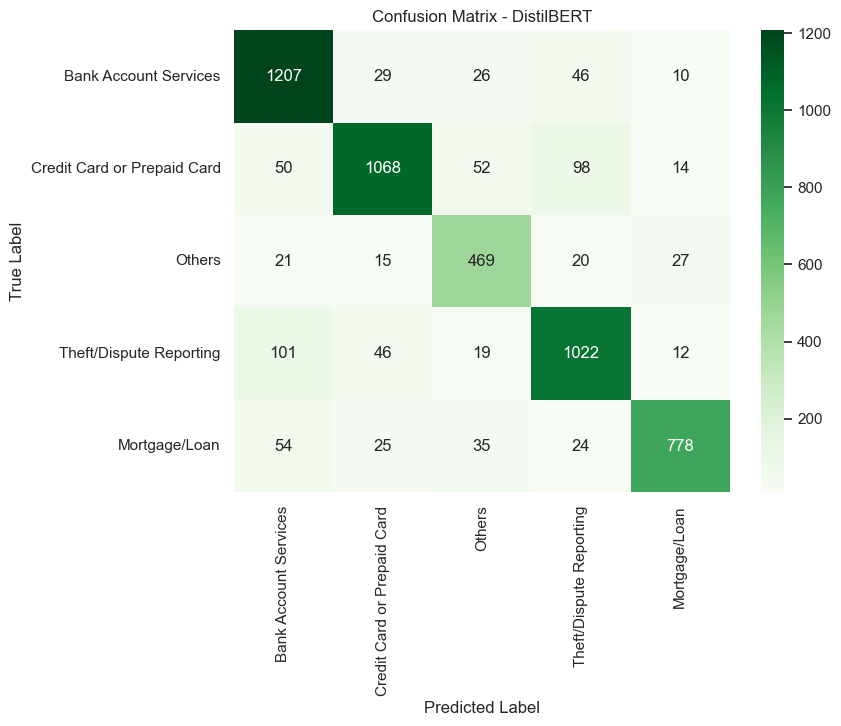

In [55]:
# Evaluation function
def evaluate_model(model, test_loader, device):
    model.eval()
    predictions = []
    true_labels = []
    
    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            
            preds = torch.argmax(outputs.logits, dim=1)
            predictions.extend(preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
    
    return predictions, true_labels

# Run evaluation
print("Evaluating model on test set...")
y_pred, y_true = evaluate_model(model, test_loader, device)

# Evaluation metrics
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def model_eval(y_test, y_pred):
    labels = [
        "Bank Account Services",
        "Credit Card or Prepaid Card",
        "Others",
        "Theft/Dispute Reporting",
        "Mortgage/Loan"
    ]
    
    # Print classification report
    print("\nCLASSIFICATION REPORT for DistilBERT\n")
    print(classification_report(y_test, y_pred, target_names=labels))
    
    # Confusion matrix
    plt.figure(figsize=(8, 6))
    plt.title("Confusion Matrix - DistilBERT")
    matrix = confusion_matrix(y_test, y_pred)
    sns.heatmap(matrix, annot=True, cmap="Greens", fmt='d', 
                xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

# Evaluate
model_eval(y_true, y_pred)

In [56]:
# Train for additional epochs with progress monitoring
num_additional_epochs = 9
print(f"Training for {num_additional_epochs} more epoch(s)...")
for epoch in range(num_additional_epochs):
    print(f"\nEpoch {epoch + 2}/{num_additional_epochs + 1}")
    train_model(model, train_loader, optimizer, device)
    
    # Quick evaluation after each epoch to track accuracy
    print(f"Evaluating after Epoch {epoch + 2}...")
    y_pred, y_true = evaluate_model(model, test_loader, device)
    accuracy = sum([1 for true, pred in zip(y_true, y_pred) if true == pred]) / len(y_true)
    print(f"Accuracy after Epoch {epoch + 2}: {accuracy:.4f}")

Training for 9 more epoch(s)...

Epoch 2/10
Batch 100/988, Loss: 0.5851
Batch 200/988, Loss: 0.1975
Batch 300/988, Loss: 0.1949
Batch 400/988, Loss: 0.2841
Batch 500/988, Loss: 0.0398
Batch 600/988, Loss: 0.3170
Batch 700/988, Loss: 0.2680
Batch 800/988, Loss: 0.3791
Batch 900/988, Loss: 0.0825
Average training loss: 0.2559
Evaluating after Epoch 2...
Accuracy after Epoch 2: 0.8459

Epoch 3/10
Batch 100/988, Loss: 0.2368
Batch 200/988, Loss: 0.0815
Batch 300/988, Loss: 0.1000
Batch 400/988, Loss: 0.1505
Batch 500/988, Loss: 0.5099
Batch 600/988, Loss: 0.4990
Batch 700/988, Loss: 0.0978
Batch 800/988, Loss: 0.6030
Batch 900/988, Loss: 0.0538
Average training loss: 0.1793
Evaluating after Epoch 3...
Accuracy after Epoch 3: 0.8677

Epoch 4/10
Batch 100/988, Loss: 0.1011
Batch 200/988, Loss: 0.1386
Batch 300/988, Loss: 0.2912
Batch 400/988, Loss: 0.0146
Batch 500/988, Loss: 0.0173
Batch 600/988, Loss: 0.1154
Batch 700/988, Loss: 0.0169
Batch 800/988, Loss: 0.0887
Batch 900/988, Loss: 0.195

Final evaluation on test set...

CLASSIFICATION REPORT for DistilBERT

                             precision    recall  f1-score   support

      Bank Account Services       0.86      0.89      0.87      1318
Credit Card or Prepaid Card       0.89      0.87      0.88      1282
                     Others       0.78      0.78      0.78       552
    Theft/Dispute Reporting       0.84      0.84      0.84      1200
              Mortgage/Loan       0.87      0.87      0.87       916

                   accuracy                           0.86      5268
                  macro avg       0.85      0.85      0.85      5268
               weighted avg       0.86      0.86      0.86      5268



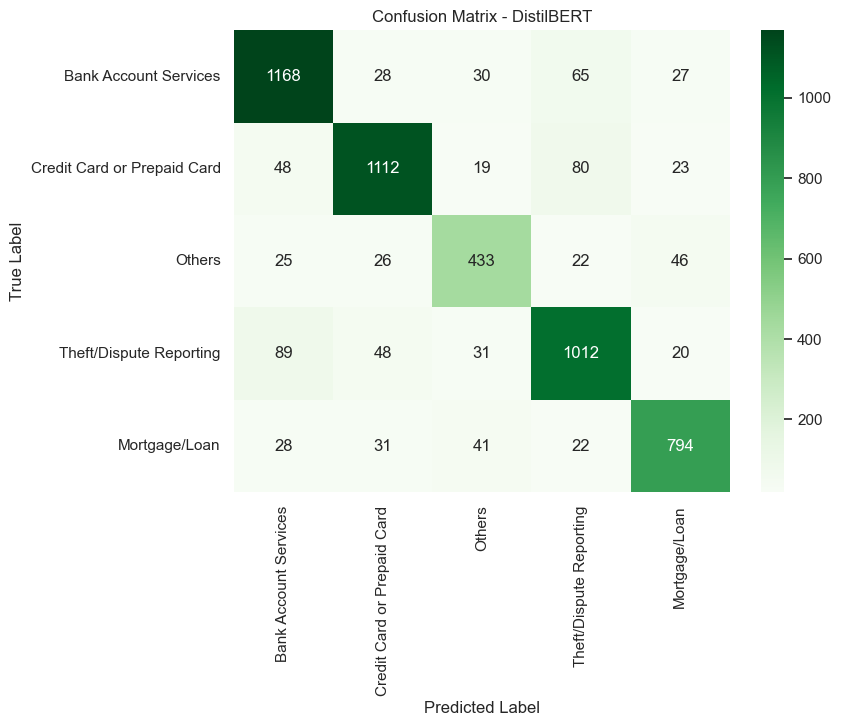

('distilbert_complaint_classifier_final/tokenizer_config.json',
 'distilbert_complaint_classifier_final/special_tokens_map.json',
 'distilbert_complaint_classifier_final/vocab.txt',
 'distilbert_complaint_classifier_final/added_tokens.json')

In [57]:
# Final evaluation with full metrics
print("Final evaluation on test set...")
y_pred, y_true = evaluate_model(model, test_loader, device)
model_eval(y_true, y_pred)

# Save the model after training
model.save_pretrained("distilbert_complaint_classifier_final")
tokenizer.save_pretrained("distilbert_complaint_classifier_final")

In [58]:
import gradio as gr
from transformers import DistilBertForSequenceClassification, DistilBertTokenizer
import torch

# Load model and tokenizer
model = DistilBertForSequenceClassification.from_pretrained("distilbert_complaint_classifier_final")
tokenizer = DistilBertTokenizer.from_pretrained("distilbert_complaint_classifier_final")

# Set the device (CPU or GPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Define topic mapping
topic_mapping = {
    0: 'Bank Account Services',
    1: 'Credit Card or Prepaid Card',
    2: 'Others',
    3: 'Theft/Dispute Reporting',
    4: 'Mortgage/Loan'
}

# Prediction function
def predict_complaint_topic(complaint_text):
    encoding = tokenizer.encode_plus(
        complaint_text,
        add_special_tokens=True,
        max_length=128,
        return_token_type_ids=False,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt'
    )
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)
    
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        predicted_class_id = torch.argmax(logits, dim=1).item()
    
    predicted_topic = topic_mapping[predicted_class_id]
    return predicted_topic

# Create Gradio interface
iface = gr.Interface(
    fn=predict_complaint_topic,  # Function to call for prediction
    inputs=gr.Textbox(label="Enter your complaint text"),  # Input type (Textbox)
    outputs=gr.Textbox(label="Predicted Complaint Topic"),  # Output type (Textbox)
    live=True,  # Enable live prediction as the user types
    title="Complaint Topic Classifier",  # Title of the app
    description="This model classifies complaints into different topics like 'Bank Account Services', 'Credit Card or Prepaid Card', etc."  # Description of the app
)

# Launch the interface
iface.launch()


* Running on local URL:  http://127.0.0.1:7862

To create a public link, set `share=True` in `launch()`.


In [1]:
import streamlit as st
from transformers import DistilBertForSequenceClassification, DistilBertTokenizer
import torch

# Load model and tokenizer
model = DistilBertForSequenceClassification.from_pretrained("distilbert_complaint_classifier_final")
tokenizer = DistilBertTokenizer.from_pretrained("distilbert_complaint_classifier_final")

# Set the device (CPU or GPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Define topic mapping
topic_mapping = {
    0: 'Bank Account Services',
    1: 'Credit Card or Prepaid Card',
    2: 'Others',
    3: 'Theft/Dispute Reporting',
    4: 'Mortgage/Loan'
}

# Prediction function
def predict_complaint_topic(complaint_text):
    encoding = tokenizer.encode_plus(
        complaint_text,
        add_special_tokens=True,
        max_length=128,
        return_token_type_ids=False,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt'
    )
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)
    
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        predicted_class_id = torch.argmax(logits, dim=1).item()
    
    predicted_topic = topic_mapping[predicted_class_id]
    return predicted_topic

# Streamlit UI setup
st.title("Complaint Topic Classifier")
st.write("This model classifies complaints into different topics like 'Bank Account Services', 'Credit Card or Prepaid Card', etc.")

# Input for complaint text
complaint_text = st.text_area("Enter your complaint text")

# Predict button
if st.button("Predict"):
    if complaint_text:
        predicted_topic = predict_complaint_topic(complaint_text)
        st.subheader("Predicted Complaint Topic")
        st.write(predicted_topic)
    else:
        st.warning("Please enter a complaint text.")


2025-04-02 23:35:18.576 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-02 23:35:18.649 
  command:

    streamlit run /opt/anaconda3/lib/python3.12/site-packages/ipykernel_launcher.py [ARGUMENTS]
2025-04-02 23:35:18.650 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-02 23:35:18.650 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-02 23:35:18.650 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-02 23:35:18.650 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-02 23:35:18.651 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-02 23:35:18.651 Thread 'MainThread': m

In [2]:
import gradio as gr
from transformers import DistilBertForSequenceClassification, DistilBertTokenizer
import torch

# Load model and tokenizer
model = DistilBertForSequenceClassification.from_pretrained("distilbert_complaint_classifier_final")
tokenizer = DistilBertTokenizer.from_pretrained("distilbert_complaint_classifier_final")

# Set the device (CPU or GPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Define topic mapping
topic_mapping = {
    0: 'Bank Account Services',
    1: 'Credit Card or Prepaid Card',
    2: 'Others',
    3: 'Theft/Dispute Reporting',
    4: 'Mortgage/Loan'
}

# Prediction function
def predict_complaint_topic(complaint_text):
    encoding = tokenizer.encode_plus(
        complaint_text,
        add_special_tokens=True,
        max_length=128,
        return_token_type_ids=False,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt'
    )
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)
    
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        predicted_class_id = torch.argmax(logits, dim=1).item()
    
    predicted_topic = topic_mapping[predicted_class_id]
    return predicted_topic

# Create Gradio interface
iface = gr.Interface(
    fn=predict_complaint_topic,  # Function to call for prediction
    inputs=gr.Textbox(label="Enter your complaint text"),  # Input type (Textbox)
    outputs=gr.Textbox(label="Predicted Complaint Topic"),  # Output type (Textbox)
    live=True,  # Enable live prediction as the user types
    title="Complaint Topic Classifier",  # Title of the app
    description="This model classifies complaints into different topics like 'Bank Account Services', 'Credit Card or Prepaid Card', etc."  # Description of the app
)

# Launch the interface with share=True for a public URL
iface.launch(share=True)


* Running on local URL:  http://127.0.0.1:7861
* Running on public URL: https://d45a77ba258ea89c61.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
